In [1]:
import os
import dotenv
dotenv.load_dotenv(".env")
from huggingface_hub import Repository, HfApi
from huggingface_hub import upload_folder

from huggingface_hub import login
login(token=os.getenv("HF_TOKEN"))

from utils import *
from data_utils import *
from visualization_utils import *
import os.path as osp
from transformers import logging
from hparam_tuning import *

logging.set_verbosity_warning()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Data
The dataset is comprised of raw English-language tweets annotated with six emotion classes.

## Cleaning
The texts in the dataset contains multiple types of noise:
- Duplicated samples - There are a couple of dozens duplicated examples with different labels in the training set
- HTML artifacts and metadata - The tweets were probably scraped directly from the website, resulting in HTML tags that are embedded into the texts
- Missing apostrophes - The data was probably normalized, replacing apostrophes with whita space. The result is "t"s and "s"s and other characters scattered around the texts.
- Slang - As customed in user produced texts in social media, the text contains heavy useage of shorthand text and slang words.
- Character repetition - The text also contains words with duplicated characters


In [25]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")

def apply_ds_clean(fn, **fn_kwargs):
    """Applies some cleaning function fn to the dataset and flags the changed rows for visualization"""
    def apply(dataset):
        text = dataset["text"]
        cleaned = fn(text, **fn_kwargs)
        return {"cleaned": cleaned,
                "is_cleaned": cleaned!= text}
    return apply

### Duplicates handling
We show 5 examples of duplicated examples with their labels. We decided to remove these examples from the dataset completely to reduces misclassification between the already closely related labels.

In [24]:
show_duplicates(dataset)

    Labels      |                                     Tweet                                      
--------------------------------------------------------------------------------------------------
(Joy/Love)      | i am not amazing or great at photography but i feel passionate about it
(Love/Joy)      | i began to feel accepted by gaia on her own terms
(Fear/Anger)    | i bet taylor swift basks in the knowledge that the boys she writes songs about probably feel tortured
(Love/Joy)      | i cant escape the tears of sadness and just true grief i feel at the loss of my sweet friend and sister
(Fear/Surprise) | i could feel myself hit this strange foggy wall


### HTML Metadata Cleaning
We employ a context-aware sliding window approach to remove HTML tags, metadata attributes, and technical noise from web-scraped text. The method uses a designated library for initial tag removal, followed by a configurable sliding window algorithm that identifies and removes sequences of technical terms while preserving legitimate words that appear in isolation, ensuring minimal loss of meaningful content.<br>
We show 5 examples. The first row in each case is the original example with the HTML metadata that was found in red. The second row is the cleaned sample.

In [26]:
dataset_cleaned = dataset.map(apply_ds_clean(clean_html_metadata, window_size=5, threshold=0.35))
show_diff(dataset_cleaned, n_cases=5, fname="html_cleaning.txt")

1) im feeling a bit gloomy and blah today so this a href http lunajubilee
   im feeling a bit gloomy and blah today so this
2) i feel foolish amazed and yet i feel foolish a href http dkang
   i feel foolish amazed and yet i feel foolish
3) i feel so honoured to receive this from krista know to the blogger world as a href https www
   i feel so honoured to receive this from krista know to the blogger world as
4) i feel all ecstatic every time i see the new old opening credits on one tree hill a href http twitter
   i feel all ecstatic every time i see the new old opening credits on one tree hill
5) i feel pleased about this issue there are a lot of beautiful pieces in it for example maggie lees poem titled a href http vol
   i feel pleased about this issue there are a lot of beautiful pieces in it for example maggie lees poem


### Fixing Missing Apostrophes
USing pattern matching we trace the stray characters and fix the the contraction.<br>
We show 5 examples. The first row is the original example with the corrupted contraction colored red. The second row is the fixed contraction colored green.

In [27]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_missing_apostrophes))
show_diff(dataset_cleaned, n_cases=5,fname="fixed_apos.txt")

1) i discovered that it gave me a great feeling of satisfaction to produce a blog post a delicious dish a few photos a written recipe that tangible job completed feeling that s rare in my life as a stay at home mom
   i discovered that it gave me a great feeling of satisfaction to produce a blog post a delicious dish a few photos a written recipe that tangible job completed feeling that's rare in my life as a stay at home mom
2) i feel like i have to pee already just thinking about this thing poking at my g spot but i m determined to find a stimulation method i enjoy
   i feel like i have to pee already just thinking about this thing poking at my g spot but i'm determined to find a stimulation method i enjoy
3) i don t feel stressed
   i don't feel stressed
4) i am feeling it and it s really ok
   i am feeling it and it's really ok
5) i did not feel inhibited by the fact that the woman s clodia s husband sorry i mean brother i always make that slip is my personal enemy everitt
   i did

### Normalizing Slang
We utilize a dictionary of common slang words and shorthand writings to normalize slang words and replace abbreviations.<br>
We show 5 examples. The first row of each examples is the original sample with the slang/abbreviation colored red. The second row shows the normalized samples with the correction colored green.

In [10]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_slang_text))
show_diff(dataset_cleaned, n_cases=5, fname="slang_norm.txt")


1) i am definitely feeling the festive vibe and i have been busy with christmas y things mince pies are very much a british xmas goodie that i had never heard of before i met my husband well maybe in a song but other than that
   i am definitely feeling the festive vibe and i have been busy with christmas why things mince pies are very much a british xmas goodie that i had never heard of before i met my husband well maybe in a song but other than that
2) i wanted to use older kx forks wheel w disc brakes but am was not feeling adventurous enough to try to figure out a stem and lowering the off road height
   i wanted to use older kx forks wheel with disc brakes but am was not feeling adventurous enough to try to figure out a stem and lowering the off road height
3) i wanna talk tell you about sycf it stands for singapore youth chinese forum btw and although theres a singapore word inside i feel like the minority there p ok but thats beside the point
   i wanna talk tell you about sycf 

### Normalizing Contractions
After fixing the missing apostrophese and normalizing the slang we also expand all the contractions using a built in python library.<br>
We show 5 examples. The first row show the original sample and the second row shows the normalized example with the expanded contraction in green. 

In [28]:
dataset_cleaned = dataset.map(apply_ds_clean(fix_contructions))
show_diff(dataset_cleaned, n_cases=5, fname="contructions.txt")

1) im feeling a little gun shy about this
   i am feeling a little gun shy about this
2) i know ken has this down but im feeling really inadequate what am i doing wrong
   i know ken has this down but i am feeling really inadequate what am i doing wrong
3) ive come up with essentially tracks momentum gradually which i feel is as important as game to game results
   i have come up with essentially tracks momentum gradually which i feel is as important as game to game results
4) i don t feel like i m unsuccessful when i fail at reaching a goal in my freelance writing career
   i do not feel like i am unsuccessful when i fail at reaching a goal in my freelance writing career
5) i wake up feeling all beaten up and i dont feel that way right now im probably going to be tempted to do the lake again
   i wake up feeling all beaten up and i do not feel that way right now i am probably going to be tempted to do the lake again


### Normalizing Repeated Characters
We identify all character repetitions of more the 2 times and replace them with dual repetitions. <br>
We show 5 examples. The first row shows the original sample with the word with character repetition in red. The second row show the normalized sample with the fixed repetition in green.

In [12]:
dataset_cleaned = dataset.map(apply_ds_clean(normalize_repeated_chars))
show_diff(dataset_cleaned, n_cases=5, fname="rep_chars.txt")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

1) i left feeling hopeful given i had felt some really good twinges releases aaaaaaand
   i left feeling hopeful given i had felt some really good twinges releases aand
2) i feel unwelcome at work sometimes and think people might be talking about me rel bookmark i feel unwelcome at work sometimes and think people might be talking about me april a class url fn n href http www
   i feel unwelcome at work sometimes and think people might be talking about me rel bookmark i feel unwelcome at work sometimes and think people might be talking about me april a class url fn n href http ww
3) i am feeling mega pathetic and clingy todayyy
   i am feeling mega pathetic and clingy todayy
4) im feeling generous lets make it a a href https www
   im feeling generous lets make it a a href https ww
5) i feel like hes trying to be the one to comfort me and help me get over yash which is sooo sweet of him but at the same time it makes me love yash more because he cant compare to yash i feel like i cant tr

### Overall Cleaning
The following show samples before and after they were processed with the entire cleaning pipeline

In [29]:
dataset_cleaned = dataset.map(apply_ds_clean(clean_sample))
show_diff(dataset_cleaned, n_cases=5, fname="total.txt")

1) i find impressive is that bezos has gone through this routine and presumably the same presentation multiple times already and will run through it multiple times after weve left with another set of reporters who will feel privileged to have gotten an audience with him
   i find impressive is that bezos has gone through this routine and presumably the same presentation multiple times already and will run through it multiple times after we have left with another set of reporters who will feel privileged to have gotten an audience with him
2) i feel foolish for how much i ve analyzed this one solitary choice to go or not to go
   i feel foolish for how much i have analyzed this one solitary choice to go or not to go
3) i couldnt help but feel a little curious about it though which is what finally led me to plan to rent it this evening
   i could not help but feel a little curious about it though which is what finally led me to plan to rent it this evening
4) im listening to right now be

# Models
## Model Types

In this work we experiment with 3 model types of different sizes:
- RoBERTa (base, large)
- ELECTRA (small, base, large)
- DeBERTa (base)

In [3]:
model_names = [
         "google/electra-small-discriminator",
         "google/electra-base-discriminator",
         "FacebookAI/roberta-base",
         "microsoft/deberta-base",
         "FacebookAI/roberta-large",
         "google/electra-large-discriminator",
]
trained_models = [
                 "nisimachluf/electra-small-tweet-classification",
                 "nisimachluf/electra-base-tweet-classification",
                 "nisimachluf/roberta-base-tweet-classification",
                 "nisimachluf/deberta-base-tweet-classification",
                 "nisimachluf/roberta-large-tweet-classification",
                 "nisimachluf/electra-large-tweet-classification",
]
ckpt_dir = "ckpts"

## Hyperparameters Tuning

In [3]:
for model_name in model_names:
    dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")    
    tune_hyperparams(model_name=model_name, dataset=dataset, weighted=True)

Loading best hyperparameters for google/electra-small-discriminator from hparams/google/electra-small-discriminator.json
Loading best hyperparameters for google/electra-base-discriminator from hparams/google/electra-base-discriminator.json
Loading best hyperparameters for FacebookAI/roberta-base from hparams/FacebookAI/roberta-base.json
Loading best hyperparameters for microsoft/deberta-base from hparams/microsoft/deberta-base.json
Loading best hyperparameters for FacebookAI/roberta-large from hparams/FacebookAI/roberta-large.json
Loading best hyperparameters for google/electra-large-discriminator from hparams/google/electra-large-discriminator.json


## Training

In [9]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")
for model_name, trained_model in zip(model_names, trained_models):
    if model_exists_on_hub(trained_model) and False:
        print("Found finetuned model for {} on the hub ({})".format(osp.basename(model_name), trained_model))
    else:
        hparams = load_hparams(model_name) #{"learning_rate": 2.0586645480619823e-05, "num_train_epochs": 12, "warmup_ratio": 0.03347555147148858, "weight_decay": 0.0148288265589339}
#         train(model_name, dataset, ckpt_dir, batch_size=32, log_results=True, trained_weights_dir="trained_weights_newst", **hparams)
    
#         # push model to hub
        local_model_path = os.path.join("trained_weights", model_name)
        upload_folder(
            folder_path=local_model_path,
            repo_id=trained_model,
            repo_type="model",
            ignore_patterns=["*.pyc", "__pycache__"]
        )

Found tuned hyperparameters for google/electra-small-discriminator at hparams/google/electra-small-discriminator.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found tuned hyperparameters for google/electra-base-discriminator at hparams/google/electra-base-discriminator.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found tuned hyperparameters for FacebookAI/roberta-base at hparams/FacebookAI/roberta-base.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found tuned hyperparameters for microsoft/deberta-base at hparams/microsoft/deberta-base.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found tuned hyperparameters for FacebookAI/roberta-large at hparams/FacebookAI/roberta-large.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found tuned hyperparameters for google/electra-large-discriminator at hparams/google/electra-large-discriminator.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


## Evaluation

In [12]:
dataset = load_csv_to_dataset("data/train.csv", "data/validation.csv")

for trained_model in trained_models:
    results = predict_on_dataset(trained_model, dataset, cache_file="cached_results/predictions.json")


Loading model: electra-small


Inference: 100%|██████████| 63/63 [00:01<00:00, 34.12it/s]


Saving results to cached_results/predictions.json
Loading model: electra-base


Inference: 100%|██████████| 63/63 [00:02<00:00, 30.27it/s]


Saving results to cached_results/predictions.json
Loading model: roberta-base


Inference: 100%|██████████| 63/63 [00:01<00:00, 32.78it/s]


Saving results to cached_results/predictions.json
Loading model: deberta-base


Inference: 100%|██████████| 63/63 [00:03<00:00, 20.03it/s]


Saving results to cached_results/predictions.json
Loading model: roberta-large


Inference: 100%|██████████| 63/63 [00:04<00:00, 13.12it/s]


Saving results to cached_results/predictions.json
Loading model: electra-large


Inference: 100%|██████████| 63/63 [00:05<00:00, 12.40it/s]


Saving results to cached_results/predictions.json


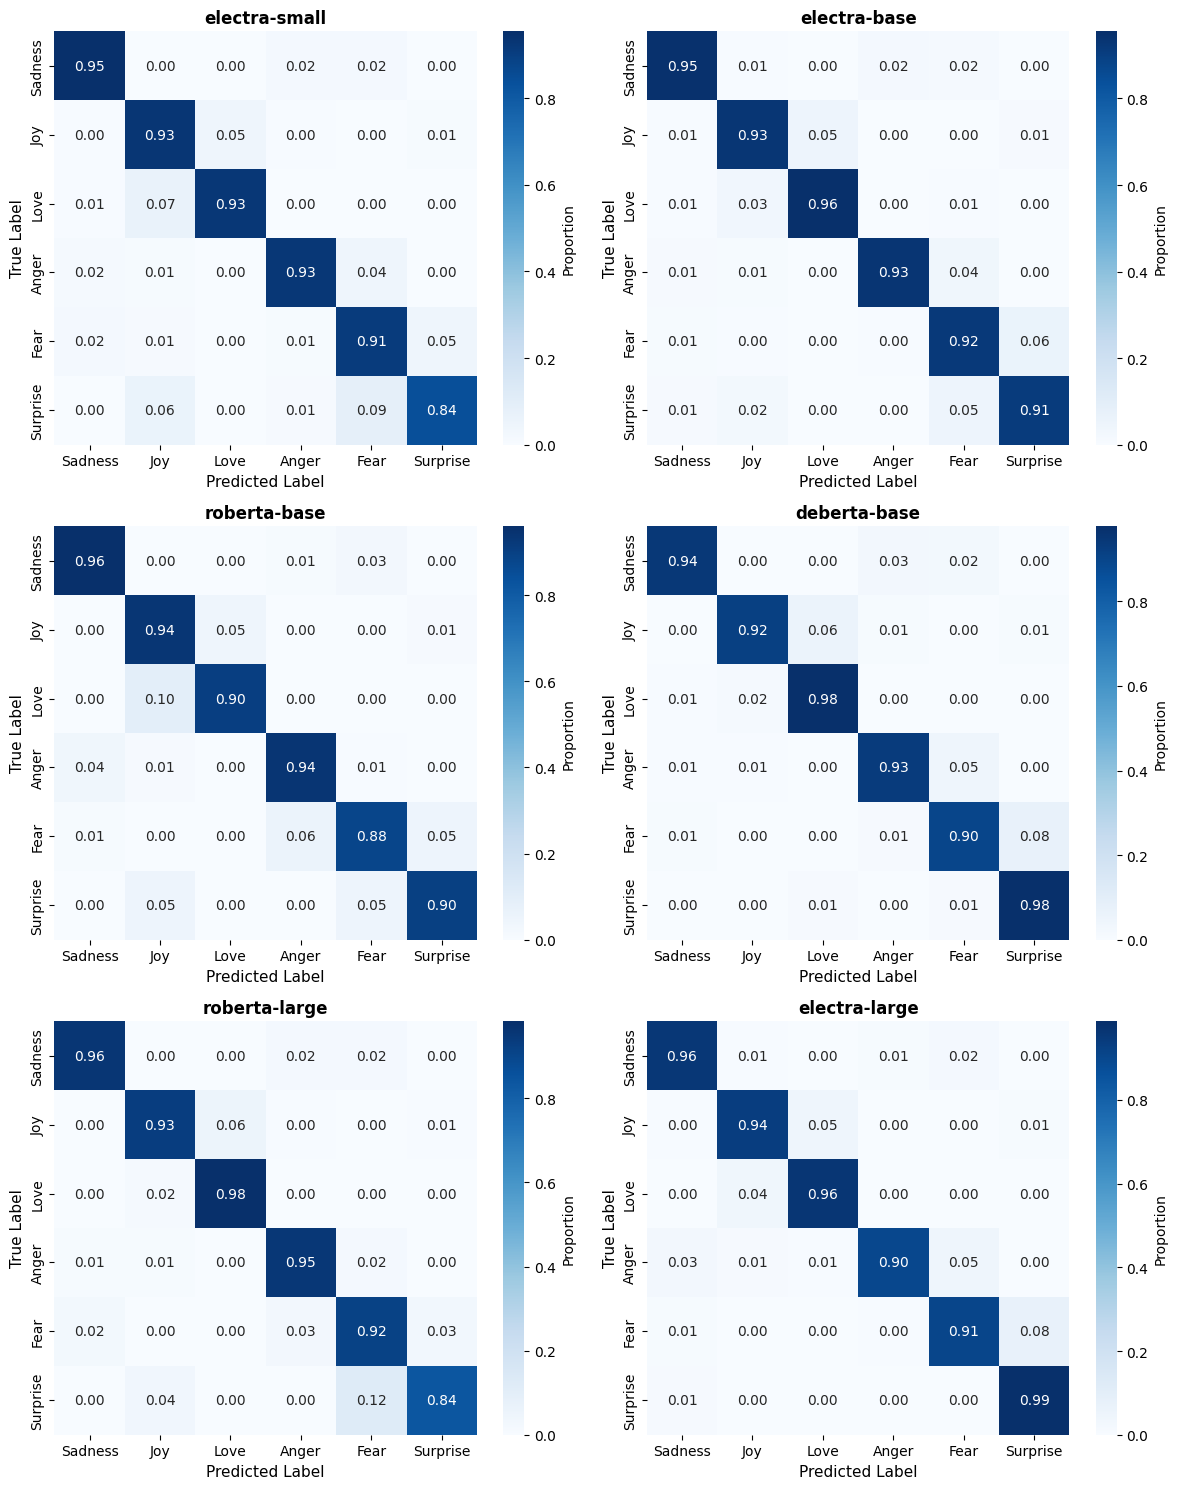

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


    
plot_confusion_matrices(predictions_cache_path="cached_results/predictions.json", fname="plots/confusion_matrices", selected_model="electra-base", selected_model_fpath="plots/confusion_matrix_electra-base")

Loading cached TSNE features for electra-small (pretrained)
Loading cached metrics for electra-small (pretrained)
Loading cached TSNE features for electra-small (finetuned)
Loading cached metrics for electra-small (finetuned)
Loading cached TSNE features for electra-base (pretrained)
Loading cached metrics for electra-base (pretrained)
Loading cached TSNE features for electra-base (finetuned)
Loading cached metrics for electra-base (finetuned)
Loading cached TSNE features for roberta-base (pretrained)
Loading cached metrics for roberta-base (pretrained)
Loading cached TSNE features for roberta-base (finetuned)
Loading cached metrics for roberta-base (finetuned)
Loading cached TSNE features for deberta-base (pretrained)
Loading cached metrics for deberta-base (pretrained)
Loading cached TSNE features for deberta-base (finetuned)
Loading cached metrics for deberta-base (finetuned)
Loading cached TSNE features for roberta-large (pretrained)
Loading cached metrics for roberta-large (pretra

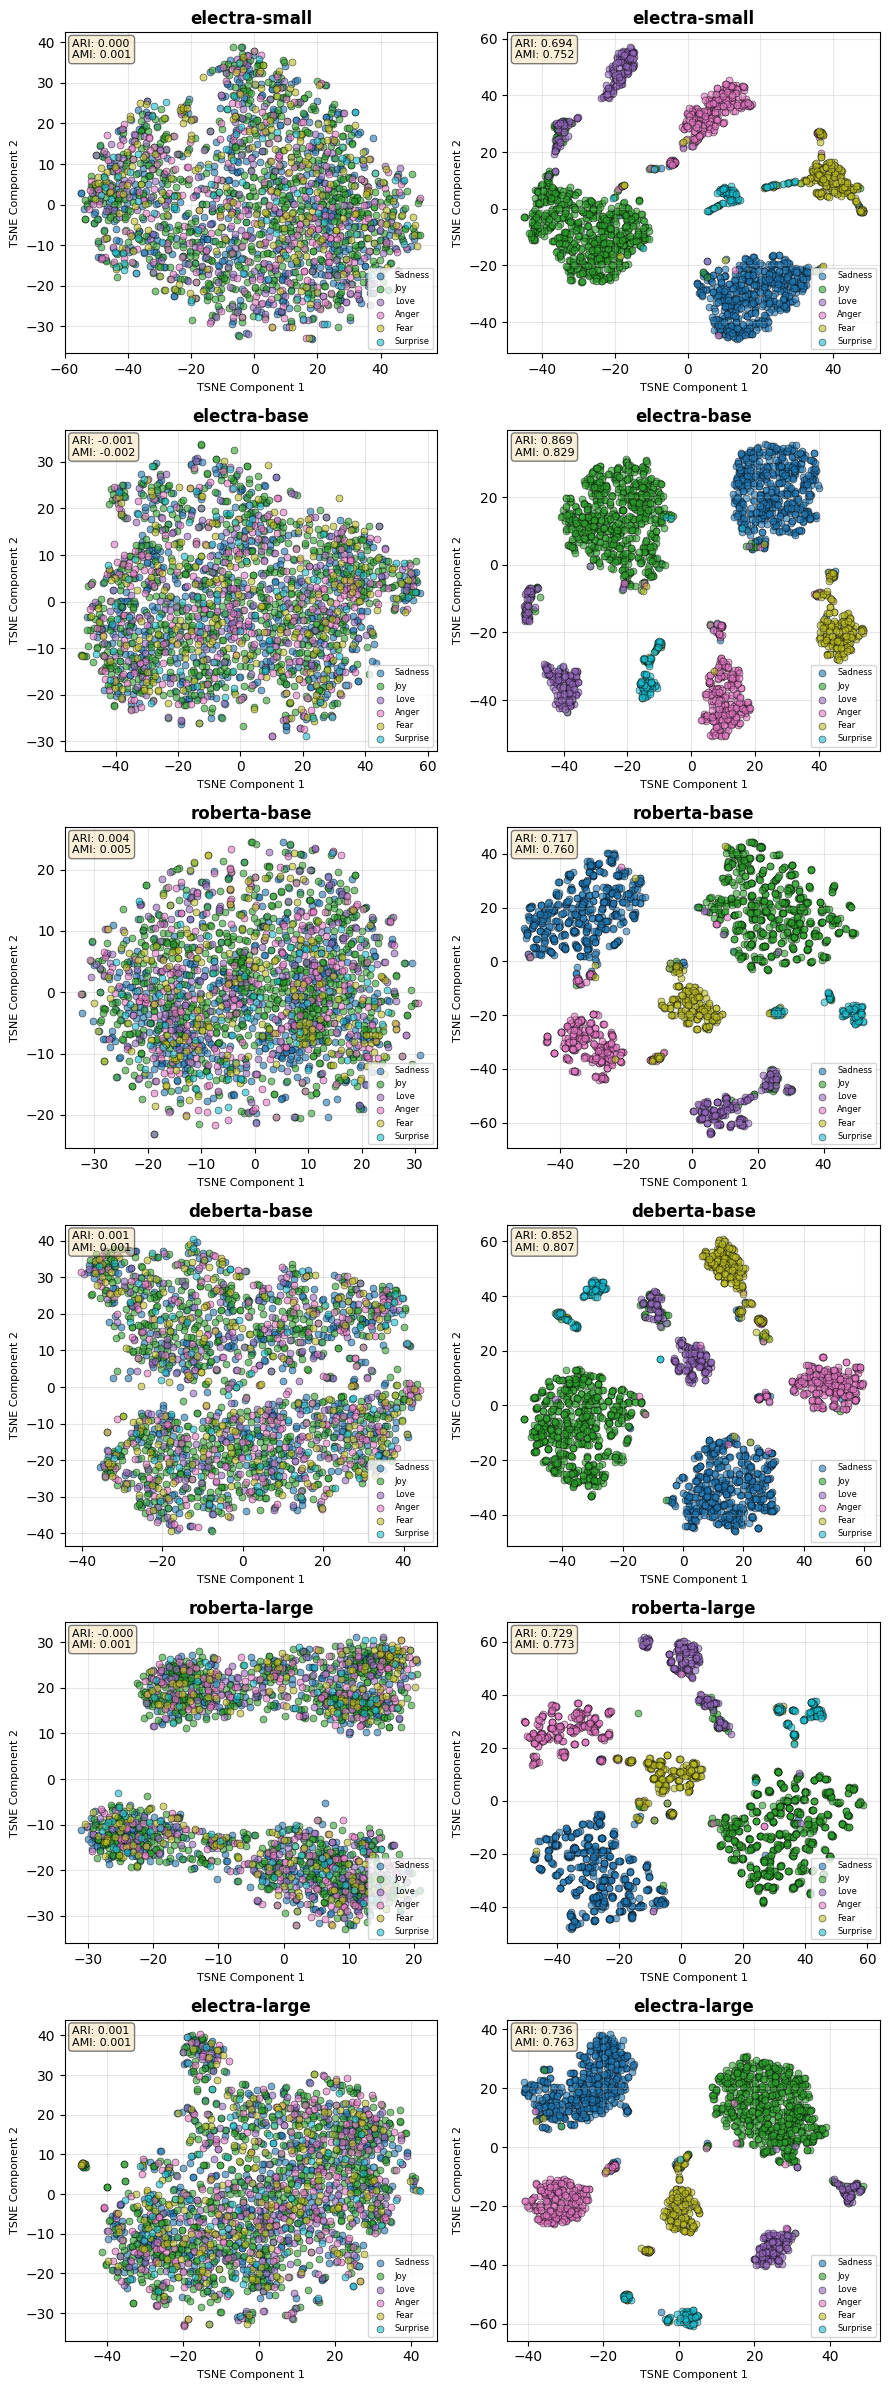

In [11]:
plot_feature_comparison(model_names, trained_models, dataset["test"], 
                            label_mapping_path='classes.json', fname="plots/feature_separation", 
                            selected_model="nisimachluf/electra-base-tweet-classification", selected_model_fpath="plots/feature_separation-electra_base",
                            method='tsne', features_cache_dir='cached_results/features')

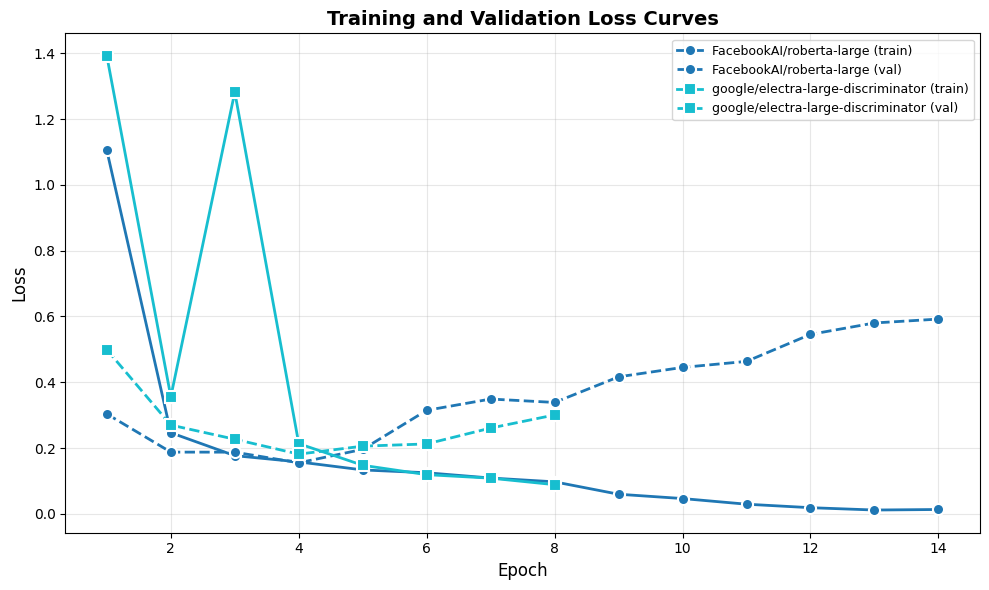

In [12]:
import pandas as pd

def plot_training_curves(trained_weights_dir='trained_weights', fname=None):
    """
    Plot training and validation loss curves for all models in trained_weights directory.
    
    Each subdirectory in trained_weights should contain model folders with training_log.csv files.
    The function plots all models on the same axes with different colors, using solid lines for 
    training loss and dashed lines for validation loss.
    
    Args:
        trained_weights_dir: Path to directory containing trained model weights (default: 'trained_weights')
        fname: Optional file path to save the figure (without extension, will be saved as .jpg)
    """
    # Find all training_log.csv files
    training_logs = []
    for root, dirs, files in os.walk(trained_weights_dir):
        if "large" in root:
            if 'training_log.csv' in files:
                log_path = os.path.join(root, 'training_log.csv')
                # Extract model name from path (e.g., 'google/electra-small-discriminator')
                rel_path = os.path.relpath(root, trained_weights_dir)
                model_name = rel_path.replace(os.sep, '/')
                training_logs.append((model_name, log_path))
    
    if not training_logs:
        print(f"No training_log.csv files found in {trained_weights_dir}")
        return
    
    # Define colors and markers for different models
    colors = plt.cm.tab10(np.linspace(0, 1, len(training_logs)))
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', '<', '>']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each model
    for idx, (model_name, log_path) in enumerate(training_logs):
        # Read training log
        df = pd.read_csv(log_path)
        
        # Extract epochs and losses
        epochs = df['epoch'].values
        train_loss = df['loss'].values
        eval_loss = df['eval_loss'].values
        
        color = colors[idx]
        marker = markers[idx % len(markers)]
        
        # Plot training loss (solid line with markers)
        ax.plot(epochs, train_loss, color=color, linestyle='-', marker=marker,
               label=f'{model_name} (train)', linewidth=2, markersize=8, markeredgewidth=1.5,
               markeredgecolor='white')
        
        # Plot validation loss (dashed line with markers)
        ax.plot(epochs, eval_loss, color=color, linestyle='--', marker=marker,
               label=f'{model_name} (val)', linewidth=2, markersize=8, markeredgewidth=1.5,
               markeredgecolor='white')
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if fname:
        # Ensure the directory exists
        directory = os.path.dirname(fname)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        plt.savefig(f'{fname}.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()
    
plot_training_curves()